In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import re
files_path = "/volume1/scratch/share_dir/ecsim/Harris/Finelli0b/"
f=open(files_path+"SimulationData.txt","r")
content=f.readlines()
f.close()
qom=[]
choose_x = None  # e.g., [10,50] or [[10,50],[60,100]]
choose_y = None  # e.g., [10,50] or [[10,50
choose_z = None  # e.g., [0,20] or [[0,20],[30,50]]
indexing = 'ij'  # 'ij' for matrix indexing, 'xy' for
for n in content:
    if "QOM" in n:
        qom.append(float(re.split("=",re.sub(" |\n","",n))[-1]))
    if "x-Length" in n:
        Lx=float(re.split("=",re.sub(" |\n","",n))[1])
    if "y-Length" in n:
        Ly=float(re.split("=",re.sub(" |\n","",n))[1])
    if "z-Length" in n:
        Lz=float(re.split("=",re.sub(" |\n","",n))[1])
    if "Number of cells (x)" in n:
        nxc=int(re.split("=",re.sub(" |\n","",n))[1])
    if "Number of cells (y)" in n:
        nyc=int(re.split("=",re.sub(" |\n","",n))[1])
    if "Number of cells (z)" in n:
        nzc=int(re.split("=",re.sub(" |\n","",n))[1])
    if "Time step" in n:
        dt=float(re.split("=",re.sub(" |\n","",n))[1])

# The x, y and z axes are set.
x=np.linspace(0,Lx,nxc+1)
y=np.linspace(0,Ly,nyc+1)
z=np.linspace(0,Lz,nzc+1)

if choose_x is None:
    choose_x = [0,nxc]
if choose_y is None:
    choose_y = [0,nyc]
if choose_z is None:
    choose_z = [0,nzc]       
if isinstance(choose_x[0],list):
    if isinstance(choose_y[0],list):
        raise ValueError("choose_x and choose_y must be of the same type")
    X = []
    Y = []
    if nzc > 1:
        Z = []
    for i in range(len(choose_x)): # deal with the situation where the user wants to extract multiple regions
        assert len(choose_x) == len(choose_y), "choose_x and choose_y must have the same length"
        if nzc > 1:
            assert len(choose_x) == len(choose_z), "choose_x and choose_y must have the same length"
            X_i, Y_i, Z_i = np.meshgrid(x[choose_x[i][0]:choose_x[i][1]], y[choose_y[i][0]:choose_y[i][1]], z[choose_z[i][0]:choose_z[i][1]], indexing=indexing)
            X.append(X_i)
            Y.append(Y_i)
            Z.append(Z_i)
        else:
            X_i, Y_i = np.meshgrid(x[choose_x[i][0]:choose_x[i][1]], y[choose_y[i][0]:choose_y[i][1]], indexing=indexing)
            X.append(X_i)
            Y.append(Y_i)
    X = np.concatenate(X,axis=1)
    Y = np.concatenate(Y,axis=1) 
    if nzc > 1:
        Z = np.concatenate(Z,axis=1)
else:
    if nzc > 1:
        X, Y, Z = np.meshgrid(x[choose_x[0]:choose_x[1]], y[choose_y[0]:choose_y[1]], z[choose_z[0]:choose_z[1]], indexing=indexing)
    else:
        X, Y = np.meshgrid(x[choose_x[0]:choose_x[1]], y[choose_y[0]:choose_y[1]], indexing=indexing)
X.shape, Y.shape


((192, 256), (192, 256))

In [44]:
def parse_simulation_data(files_path):
    """
    Parse SimulationData.txt file that can be in either old or new format.
    
    Old format uses key patterns like "x-Length" and "Number of cells (x)"
    New format uses "Simulation domain" and "Grid resolution" with comma-separated values
    
    Returns:
    - dict: A dictionary containing Lx, Ly, Lz, nxc, nyc, nzc, dt, and qom values
    """
    try:
        f = open(files_path + "SimulationData.txt", "r")
    except Exception:
        # Remove the last folder from files_path
        files_path = os.path.dirname(os.path.normpath(files_path)) + os.sep
        f = open(files_path + "SimulationData.txt", "r")
    
    content = f.readlines()
    f.close()
    
    # Initialize variables
    result = {
        'Lx': None, 'Ly': None, 'Lz': None,
        'nxc': None, 'nyc': None, 'nzc': None,
        'dt': None, 'qom': []
    }
    
    # Try to detect format by checking for key indicators
    content_str = ''.join(content)
    is_new_format = "Simulation domain" in content_str and "Grid resolution" in content_str
    
    if is_new_format:
        # Parse new format
        for line in content:
            line_clean = line.strip()
            
            # Parse Simulation domain (e.g., "Simulation domain = 30 x 30 x 1")
            if line_clean.startswith("Simulation domain"):
                parts = line_clean.split("=")[1].strip().split("x")
                result['Lx'] = float(parts[0].strip())
                result['Ly'] = float(parts[1].strip())
                result['Lz'] = float(parts[2].strip())
            
            # Parse Grid resolution (e.g., "Grid resolution = 100 x 100 x 1")
            elif line_clean.startswith("Grid resolution"):
                parts = line_clean.split("=")[1].strip().split("x")
                result['nxc'] = int(parts[0].strip())
                result['nyc'] = int(parts[1].strip())
                result['nzc'] = int(parts[2].strip())
            
            # Parse Time step size (e.g., "Time step size (dt) = 0.125")
            elif "Time step size" in line_clean:
                result['dt'] = float(line_clean.split("=")[1].strip())
            
            # Parse Charge-to-mass ratio
            elif "Charge-to-mass ratio" in line_clean:
                qom_val = float(line_clean.split("=")[1].strip())
                result['qom'].append(qom_val)
    else:
        # Parse old format
        for n in content:
            if "QOM" in n:
                result['qom'].append(float(re.split("=", re.sub(" |\n", "", n))[-1]))
            if "x-Length" in n:
                result['Lx'] = float(re.split("=", re.sub(" |\n", "", n))[1])
            if "y-Length" in n:
                result['Ly'] = float(re.split("=", re.sub(" |\n", "", n))[1])
            if "z-Length" in n:
                result['Lz'] = float(re.split("=", re.sub(" |\n", "", n))[1])
            if "Number of cells (x)" in n:
                result['nxc'] = int(re.split("=", re.sub(" |\n", "", n))[1])
            if "Number of cells (y)" in n:
                result['nyc'] = int(re.split("=", re.sub(" |\n", "", n))[1])
            if "Number of cells (z)" in n:
                result['nzc'] = int(re.split("=", re.sub(" |\n", "", n))[1])
            if "Time step" in n:
                result['dt'] = float(re.split("=", re.sub(" |\n", "", n))[1])
    
    return result

DEFAULT_CHOOSE_X = None
DEFAULT_CHOOSE_Y = None
DEFAULT_CHOOSE_Z = None
DEFAULT_INDEXING = 'ij'
DEFAULT_VERBOSE = False
def build_XY(files_path, choose_x=DEFAULT_CHOOSE_X, choose_y=DEFAULT_CHOOSE_Y, 
             choose_z=DEFAULT_CHOOSE_Z, indexing=DEFAULT_INDEXING):
    """
    Read grid parameters from SimulationData.txt and build coordinate meshgrids.
    Supports both old and new SimulationData.txt formats.
    """
    sim_data = parse_simulation_data(files_path)
    
    Lx = sim_data['Lx']
    Ly = sim_data['Ly']
    Lz = sim_data['Lz']
    nxc = sim_data['nxc']
    nyc = sim_data['nyc']
    nzc = sim_data['nzc']
    qom = sim_data['qom']
    
    # The x, y and z axes are set.
    x = np.linspace(0, Lx, nxc + 1)
    y = np.linspace(0, Ly, nyc + 1)
    z = np.linspace(0, Lz, nzc + 1)
    
    if choose_x is None:
        choose_x = [0, nxc]
    if choose_y is None:
        choose_y = [0, nyc]
    if choose_z is None:
        choose_z = [0, nzc]
    
    if isinstance(choose_x[0], list):
        if isinstance(choose_y[0], list):
            raise ValueError("choose_x and choose_y must be of the same type")
        X = []
        Y = []
        if nzc > 1:
            Z = []
        for i in range(len(choose_x)):  # deal with the situation where the user wants to extract multiple regions
            assert len(choose_x) == len(choose_y), "choose_x and choose_y must have the same length"
            if nzc > 1:
                assert len(choose_x) == len(choose_z), "choose_x and choose_y must have the same length"
                X_i, Y_i, Z_i = np.meshgrid(
                    x[choose_x[i][0]:choose_x[i][1]], 
                    y[choose_y[i][0]:choose_y[i][1]], 
                    z[choose_z[i][0]:choose_z[i][1]], 
                    indexing=indexing
                )
                X.append(X_i)
                Y.append(Y_i)
                Z.append(Z_i)
            else:
                X_i, Y_i = np.meshgrid(
                    x[choose_x[i][0]:choose_x[i][1]], 
                    y[choose_y[i][0]:choose_y[i][1]], 
                    indexing=indexing
                )
                X.append(X_i)
                Y.append(Y_i)
        X = np.concatenate(X, axis=1)
        Y = np.concatenate(Y, axis=1)
        if nzc > 1:
            Z = np.concatenate(Z, axis=1)
    else:
        if nzc > 1:
            X, Y, Z = np.meshgrid(
                x[choose_x[0]:choose_x[1]], 
                y[choose_y[0]:choose_y[1]], 
                z[choose_z[0]:choose_z[1]], 
                indexing=indexing
            )
        else:
            X, Y = np.meshgrid(
                x[choose_x[0]:choose_x[1]], 
                y[choose_y[0]:choose_y[1]], 
                indexing=indexing
            )
    
    if nzc > 1:
        return X, Y, Z
    else:
        return X, Y
X, Y = build_XY(files_path)
X.shape, Y.shape

((192, 256), (192, 256))

In [42]:
fieldname = "Bx"
field = []
filenames = ["DoubleGEM-Fields_013000.h5", "DoubleGEM-Fields_014000.h5", "DoubleGEM-Fields_015000.h5"]
choose_x = None
choose_y = None
choose_z = None
for filename in filenames:
    with h5py.File(files_path + filename, "r") as n:
        temp = np.array(n[f"/Step#0/Block/{fieldname}/0"])#[0,...]
        #if temp.ndim == 2:
        #    temp = temp[np.newaxis, :, :]
        if choose_x is None:
            choose_x = [0,temp.shape[2]-1]
        if choose_y is None:
            choose_y = [0,temp.shape[1]-1]
        if choose_z is None:
            choose_z = [0,temp.shape[0]-1]
        print(f"{choose_x = }, {choose_y = }, {choose_z = } with shape {temp.shape}")
        temp = np.transpose(temp[choose_z[0]:choose_z[1], choose_y[0]:choose_y[1], choose_x[0]:choose_x[1]], (2, 1, 0))  # to (z,y,x)
        print(f"Read {fieldname} from {filename} with shape {temp.shape} before squeeze")
        temp = temp.squeeze()
        
        field.append(temp)
#a = np.transpose(np.array(field), (3, 2, 1, 0))[choose_x[0]:choose_x[1], choose_y[0]:choose_y[1], choose_z[0]:choose_z[1]]
#a = np.squeeze(a[...,0,:])
a = np.moveaxis(np.array(field), 0, -1)
a.shape

choose_x = [0, 192], choose_y = [0, 256], choose_z = [0, 1] with shape (2, 257, 193)
Read Bx from DoubleGEM-Fields_013000.h5 with shape (192, 256, 1) before squeeze
choose_x = [0, 192], choose_y = [0, 256], choose_z = [0, 1] with shape (2, 257, 193)
Read Bx from DoubleGEM-Fields_014000.h5 with shape (192, 256, 1) before squeeze
choose_x = [0, 192], choose_y = [0, 256], choose_z = [0, 1] with shape (2, 257, 193)
Read Bx from DoubleGEM-Fields_015000.h5 with shape (192, 256, 1) before squeeze


(192, 256, 3)

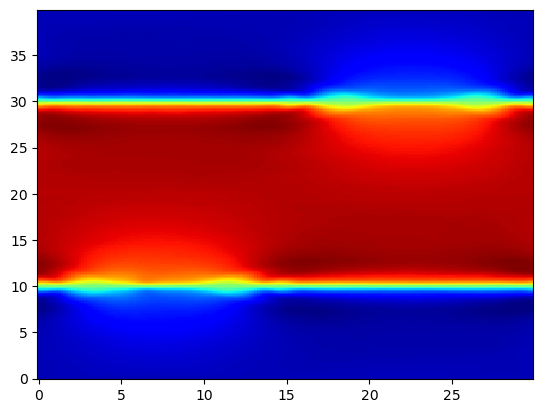

In [43]:
plt.pcolormesh(X,Y,a[...,0], cmap='jet')